<a href="https://colab.research.google.com/github/UmarNauruzov/Neural_network/blob/main/%D0%9F%D0%BE%D1%81%D1%82%D1%80%D0%BE%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8_%D0%B3%D0%BB%D1%83%D0%B1%D0%BE%D0%BA%D0%BE%D0%B3%D0%BE_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Зададим гиперпараметры модели

In [1]:
epsilon = 1 # Параметр эпсилон при использовании эпсилон жадной стратегии
gamma = 0.9 # Коэффциент дисконтирования гамма
random_seed = 1212131 #Random seed
time_delay = 1 # Задержка времени при отрисовке процесса игры после обучения (секунды)
lr_rate = 0.9 #Коэффициент скорости обучения альфа

Импортируем библиотеки, создаем свою среду размера 6х6. S обозначает точку старта. F -- лед безопасен, H -- проталина, G -- цель. Параметр `is_slippery=False` отвечает за условное отсутствие скольжения. То есть если агент выбрал действие пойти направо, то он переместится в соответствующее состояние. В общем случае из-за "скольжения" можно оказаться в другом состоянии. Мы также скопировали из библиотки GYM и слегка модифицировали функцию ```generate_random_map ```, для того, чтобы генерировать произвольные карты на основе ```random_seed ```.





In [2]:
!pip install -q --upgrade gym==0.18.0
import gym
import numpy as np
import time
from IPython.display import clear_output


def generate_random_map(size, p, sd):
    """Генерирует случайную действительную карту (ту, которая имеет путь от начала до цели)
      :размер параметра: размер каждой стороны сетки
      :параметр p: вероятность того, что плитка заморожена
    """
    valid = False
    np.random.seed(sd)

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0,0))
        while frontier:
            r, c = frontier.pop()
            if not (r,c) in discovered:
                discovered.add((r,c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] not in '#H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]

#Генерация карты
random_map = generate_random_map(size=6, p=0.8, sd = random_seed) #Создаем свою карту
env = gym.make("FrozenLake-v0", desc=random_map, is_slippery=False) #Инициализируем среду
print("Карта")
env.render() #Выводим карту на экран

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.1/39.1 MB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Карта

SFFFFF
FFFFFF
FFFHFH
FFFFHF
FFFFFF
HFHFFG


Функции выбора действия и обновления таблицы ценности действий. Строчка *** используется для того, чтобы проверять ответы в openedx. Вне рамках академической задачи лучше использовать оригинальный метод класса `environment`, то есть:

`action = env.action_space.sample()`


Функция ```learn()``` в результате ее вызова обновляет значение ценности текущего действия согласно алгоритму Q-обучения



In [ ]:
def choose_action(state):
    action=0
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0,env.action_space.n) #***
    else:
        action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

def learn(state, state2, reward, action, done):
    if done is True:
        Q[state, action] = Q[state, action] + lr_rate*(reward - Q[state, action])
    else:
        Q[state, action] = Q[state, action] + lr_rate * (reward + gamma*np.max(Q[state2,:])-Q[state, action])


Функция ```env.step(action)```

```state2``` -- следующее состояние

```reward``` -- награда

```done``` -- флаг окончания игры. True в случае победы или падения в проталину. False в остальных случаях.




In [ ]:
from tqdm import tqdm
# Inititalization
np.random.seed(random_seed)
total_games = 10000
max_steps = 100
Q = np.zeros((env.observation_space.n, env.action_space.n))
#Main cycle
game1= [0]*total_games
for game in tqdm(range(total_games)):
    state = env.reset()
    t = 0
    while t < max_steps:
        
        t += 1

        action = choose_action(state)

        state2, reward, done, info = env.step(action)

        if t == max_steps:
          done = True  

        learn(state, state2, reward, action, done)

        state = state2

        if done:
            if reward == 1:
                game1[game]=1
            break

def get_fg_and_v(game):
    #количество побед
    pobeda = 0
    #количество побед подряд
    pp=0
    i=0
    l=[]
    for g in game:
        if g == 1:
            pobeda=pobeda+1
            if len(l) ==0:
                l.append(i)
            else:
                if len(l) <5:
                    if l[-1] - i == -1:
                        l.append(i)
                    else:
                        l=[i]
                    if len(l) == 5 and pp==0:
                        pp = i+1
 
        i=i+1
    return pp, pobeda

pp, pobeda = get_fg_and_v(game1)



100%|██████████| 10000/10000 [00:12<00:00, 784.74it/s]


In [ ]:
from tqdm import tqdm
# Inititalization
wins_arr = [] #delete
np.random.seed(random_seed)
total_episodes = 10000
max_steps = 100
Q = np.zeros((env.observation_space.n, env.action_space.n))
min_episode = 0 #delete
#Main cycle
for episode in tqdm(range(total_episodes)):
    state = env.reset()
    t = 0
    while t < max_steps:
      #delete
        if episode > 5 and wins_arr[episode-5] == 1 and wins_arr[episode-4] == 1 and wins_arr[episode-3] == 1 and wins_arr[episode-2] == 1 and wins_arr[episode-1] == 1 and min_episode ==0:
          min_episode = episode
        
        t += 1

        action = choose_action(state)

        state2, reward, done, info = env.step(action)

        if t == max_steps:
          done = True  

        learn(state, state2, reward, action, done)

        state = state2


        if done and reward == 1:
          wins_arr.append(1) #record if won
          break
        if done:
          wins_arr.append(0) #record if lost
          break

In [ ]:
#print("Таблица ценностей действий")
#print(np.round(Q,4))
#Number of wins
print("Количество побед в серии из 10 000 игр: ", np.sum(wins_arr))
#Number of the episode
print("Пять побед подряд впервые было одержано в игре ",min_episode)
#print("Q-table")
#print(np.round(Q,2))
#print("Number of wins: ", #your code here)
#print("Number of the episode", #your code here)

Вывод ответов при заданных параметрах

In [ ]:
print("Количество побед в серии из 10 000 игр: ", pobeda)
print("Пять побед подряд впервые было одержано в игре ", pp)

Количество побед в серии из 10 000 игр:  129
Пять побед подряд впервые было одержано в игре  0


Произведем одну игру, чтобы проследить за действиями агента. При этом будем считать модель полностью обученной, то есть действия выбираются жадно, значения ценностей действий в таблице не обновляются.

In [ ]:
import time
#Жадный выбор действий
def choose_action_one_game(state):
    action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

states=[]#Массив для сохранения состояний агента в течение игры
t = 0
state = env.reset()
wn = 0
while(t<100):
  env.render()
  time.sleep(time_delay)
  clear_output(wait=True)
  action = choose_action_one_game(state)  
  state2, reward, done, info = env.step(action)  
  states.append(state)
  state = state2
  t += 1
  if done and reward == 1:
    wn=1
  if done:
    break
if wn == 1:
  print("!!!Победа!!!")

!!!Победа!!!


Отобразим маршрут

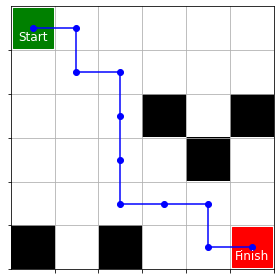

In [ ]:
import matplotlib.pyplot as plt

def make_maze_pic(maze):
  maze_pic=[]
  for i in range(len(maze)):
    row = []
    for j in range(len(maze[i])):
      if maze[i][j] == 'S':
        row.append(0)
      if maze[i][j] == 'F':
        row.append(0)
      if maze[i][j] == 'H':
        row.append(1)
      if maze[i][j] == 'G':
        row.append(0)
    maze_pic.append(row)
  maze_pic = np.array(maze_pic)
  return maze_pic
  

#Make maze fit to plot
maze_pic = make_maze_pic(random_map)
nrows, ncols = maze_pic.shape

#Arrays of picture elements
rw = np.remainder(states,nrows)
cl = np.floor_divide(states,nrows)
if wn == 1:
  rw = np.append(rw, [nrows-1])
  cl = np.append(cl,[ncols-1])

#Picture plotting
fig, ax1 = plt.subplots(1, 1, tight_layout=True)
ax1.clear()
ax1.set_xticks(np.arange(0.5, nrows, step=1))
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0.5, ncols, step=1))
ax1.set_yticklabels([])
ax1.grid(True)
ax1.plot([0],[0], "gs", markersize=40)  # start is a big green square
ax1.text(0, 0.2,"Start", ha="center", va="center", color="white", fontsize=12) #Start text
ax1.plot([nrows-1],[ncols-1], "rs", markersize=40)  # exit is a big red square
ax1.text(nrows-1, ncols-1+0.2,"Finish", ha="center", va="center", color="white", fontsize=12) #Exit text
ax1.plot(rw,cl, ls = '-', color = 'blue') #Blue lines path
ax1.plot(rw,cl, "bo")  # Blue dots visited cells
ax1.imshow(maze_pic, cmap="binary")